####                                                                    AAI-530-GROUP3-FINAL-PROJECT-SMARTAQ

### Objective: 

The goal of this project is to develop a medium-term prediction model for PM2.5 concentrations in Beijing using deep learning techniques, specifically Long Short-Term Memory (LSTM)

networks. Given the hourly recorded PM2.5 data and meteorological variables from 2010 to 2015, the project aims to predict PM2.5 and IWS levels for the next 7 days using historical trends,

seasonal variations, and meteorological influences.



By leveraging past PM2.5 and IWS readings and meteorological conditions (temperature, atmospheric pressure, rainfall, snowfall, and dew point), the model will:

•	Quantify pollution trends over time.

•	Incorporate meteorological dependencies to refine PM2.5 predictions.

•	Identify seasonal variations in pollution patterns.

•	Assess policy effectiveness by analyzing historical and predicted trends.


The insights from this forecasting model will assist policymakers and environmental agencies in monitoring air pollution trends, implementing proactive pollution control measures, and 

assessing the impact of policy interventions like emission reductions and energy transitions.

### import all the libraries

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**Loading the dataset**

The features in th dataset are ,

No (Index/Serial Number): A unique identifier for each row in the dataset.

Year: The year in which the PM2.5 and meteorological data were recorded (2010–2015).

Month: The month (1–12) in which the data was recorded.Useful for capturing seasonal variations in PM2.5 levels and IWS levels .For example, higher levels in winter due to coal-based heating.

Day: The day of the month when the data was recorded (1–31).

Hour: The hour of the day when the data was recorded (0–23).

Dew Point: Dew point temperature.

Temperature: Atmospheric temperature in Celsius.

Pressure: Atmospheric pressure in hPa.

CBWD (Combined Wind Direction): A categorical variable representing wind direction (e.g., NW, NE, SW, SE).

IWS (Integrated Wind Speed):  The cumulative wind speed in meters per second (m/s) over a specific period.

IS (Integrated Snowfall): The cumulative snowfall in millimeters (mm) over a specific period.

IR (Integrated Rainfall): The cumulative rainfall in millimeters (mm) over a specific period.

PM2.5 (Target Variable): The concentration of fine particulate matter (PM2.5) in micrograms per cubic meter (µg/m³).






## data ingestion

In [55]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'

df_raw = pd.read_csv(url)

df_raw.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [ ]:
# zip_path = "beijing+pm2+5+data.zip"

# # Opening the ZIP file
# with zipfile.ZipFile(zip_path, 'r') as z:
#     file_list = z.namelist()
#     print("Files in zip:", file_list)  

#     with z.open("PRSA_data_2010.1.1-2014.12.31.csv") as f:
#         df_raw = pd.read_csv(f, delimiter=",", low_memory=False)

# print(df_raw.head())

Files in zip: ['PRSA_data_2010.1.1-2014.12.31.csv']
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


In [56]:
df_raw.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


1. From the above observations it is found that pm2.5 has 41,757 non-null values, while other features have 43,824 values. This means 2,067 missing values in pm2.5 (≈4.7% of the data). So we are using linear interpolation to fill missing values smoothly.

2. distribution of pm2.5 : Mean pm2.5 = 98.61 µg/m³ (High pollution on average), Std Dev = 92.05 → Large spread, meaning significant variations in pollution levels. Min = 0, Max = 994  Wide range, indicating extreme pollution days.  high standard deviation suggests frequent fluctuations in pollution levels.

3. 	Temperature (TEMP):
    Mean: 12.45°C, Min: -19°C, Max: 42°C.
    Winter temperatures go as low as -19°C, possibly linked to higher coal-based heating emissions.
    Higher PM2.5 levels are expected in winter due to increased coal burning.

4. Seasonal variations significantly affect PM2.5 levels—higher pollution in winter due to coal heating & stagnant air conditions.

5. Wind speed analysis is crucial to predicting PM2.5 levels since strong winds can clear pollution.

6. Very little snowfall overall, meaning snow is unlikely to have a major impact on pollution.

7. Rainfall events can be explored to understand PM2.5 reduction during precipitation days.

8. Comparing different years will reveal if pollution worsened or improved.

9. Higher pollution expected in winter (December–February) due to heating emissions. Lower pollution expected in summer (June–August) due to stronger winds & rainfall.

In [57]:
df_raw.dtypes

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [58]:
#create a datetime feature from year,month,day and hour features
df_raw['datetime'] = pd.to_datetime(df_raw[['year', 'month', 'day', 'hour']])

# Format the Datetime column as yyyy-mm-dd HH:mm:ss
df_raw['datetime'] = df_raw['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# first few rows to verify
df_raw.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [59]:
df_raw.tail()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,2014-12-31 19:00:00
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,2014-12-31 20:00:00
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,2014-12-31 21:00:00
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,2014-12-31 22:00:00
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0,2014-12-31 23:00:00


In [60]:
df = df_raw.copy()

In [61]:

# Create Datetime Column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Convert to Unix Timestamp (Seconds since 1970-01-01)
df['unix_time'] = df['datetime'].astype('int64') // 10**9  # Convert to seconds

In [62]:
df[['datetime', 'unix_time']].head()

,datetime,unix_time
0,2010-01-01 00:00:00,1262304000
1,2010-01-01 01:00:00,1262307600
2,2010-01-01 02:00:00,1262311200
3,2010-01-01 03:00:00,1262314800
4,2010-01-01 04:00:00,1262318400


## data cleaning

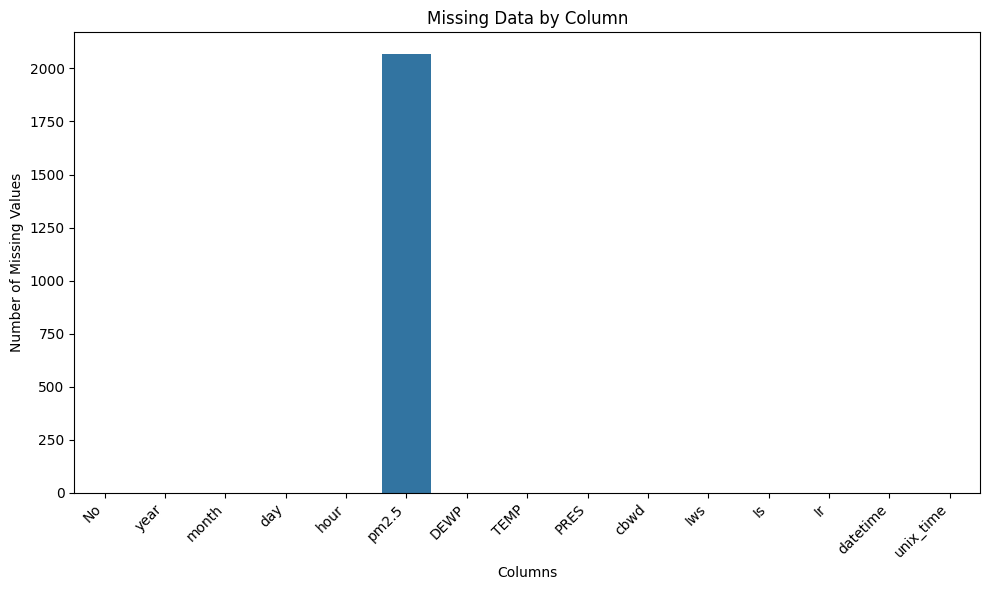

In [63]:
# Check for missing values
missing_counts = df.isnull().sum()

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_counts.index, y=missing_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Missing Data by Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'NaN Counts Over Time'}, xlabel='datetime'>

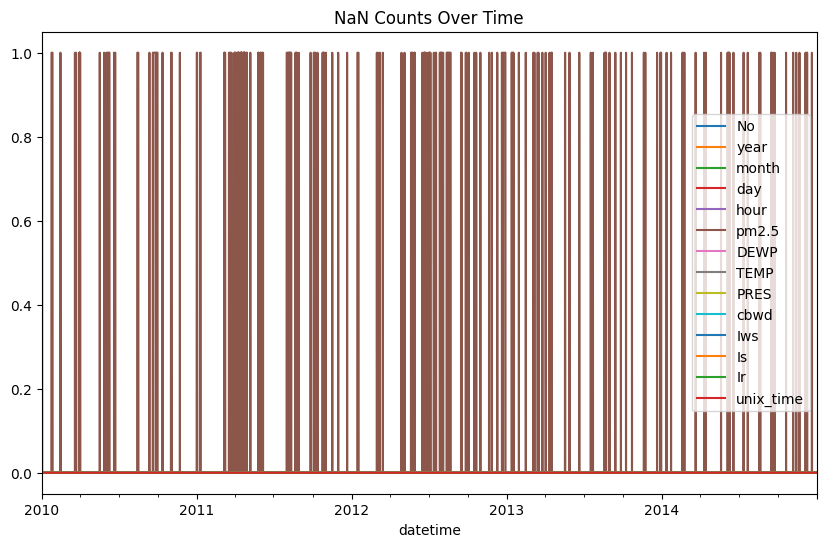

In [64]:
# Drop unwanted columns for NaN analysis (excluding 'Datetime' or 'Date')
df_na = df.drop('datetime', axis=1).isna().groupby(df['datetime'], sort=False).sum().reset_index()

# Plot NaN counts over time using 'Datetime' as x-axis
df_na.plot(x='datetime', y=df_na.columns[1:], figsize=(10, 6), title="NaN Counts Over Time")

These missing values are distributed throughout the dataset and are not uniformly distributed.Certain periods show clusters of missing values (entire sections are missing) and Other periods have sporadic gaps. Missing data in pm2.5 might be due to sensor failure, data collection issues, or external factors like weather or maintenance. This pattern suggests the need to investigate if missing data aligns with specific months, seasons, or hours of the day. Gaps in pm2.5 data could affect trend and seasonal analysis. Imputation or interpolation will likely be needed. The high number of missing values might make it challenging to perform accurate predictions without a robust handling strategy. 

In [65]:
missing_percent = df.isnull().mean() * 100
print(missing_percent)

No           0.000000
year         0.000000
month        0.000000
day          0.000000
hour         0.000000
pm2.5        4.716594
DEWP         0.000000
TEMP         0.000000
PRES         0.000000
cbwd         0.000000
Iws          0.000000
Is           0.000000
Ir           0.000000
datetime     0.000000
unix_time    0.000000
dtype: float64


A missing rate of 4.71% is relatively low and manageable in most cases. Handling missing data will affect a small portion of your dataset, so most of the data remains intact for analysis.

In [66]:
#linear interpolation for numeric columns to fill missing values
df_numeric = df.drop(columns=['datetime'])  # Exclude non-numeric columns
df_numeric = df_numeric.interpolate(method='linear', limit_direction='both')

# Replace original numeric columns with imputed values
df.update(df_numeric)

# Verify missing data is handled
print(df.isna().sum())

No           0
year         0
month        0
day          0
hour         0
pm2.5        0
DEWP         0
TEMP         0
PRES         0
cbwd         0
Iws          0
Is           0
Ir           0
datetime     0
unix_time    0
dtype: int64


/var/folders/1y/p5k2q_ms1kqfyyfj3ptdpwsc0000gn/T/ipykernel_76336/2951410894.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_numeric = df_numeric.interpolate(method='linear', limit_direction='both')


In [67]:
desc = df.describe()

print(desc)

                 No          year         month           day          hour  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean   21912.500000   2012.000000      6.523549     15.727820     11.500000   
min        1.000000   2010.000000      1.000000      1.000000      0.000000   
25%    10956.750000   2011.000000      4.000000      8.000000      5.750000   
50%    21912.500000   2012.000000      7.000000     16.000000     11.500000   
75%    32868.250000   2013.000000     10.000000     23.000000     17.250000   
max    43824.000000   2014.000000     12.000000     31.000000     23.000000   
std    12651.043435      1.413842      3.448572      8.799425      6.922266   

              pm2.5          DEWP          TEMP          PRES           Iws  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean      98.261809      1.817246     12.448521   1016.447654     23.889140   
min        0.000000    -40.000000    -19.000000    

In [68]:
# Count rows NOT between 2010 and 2014
count_outside_range = df[(df['year'] < 2010) | (df['year'] > 2014)].shape[0]

# Display the count
count_outside_range

0

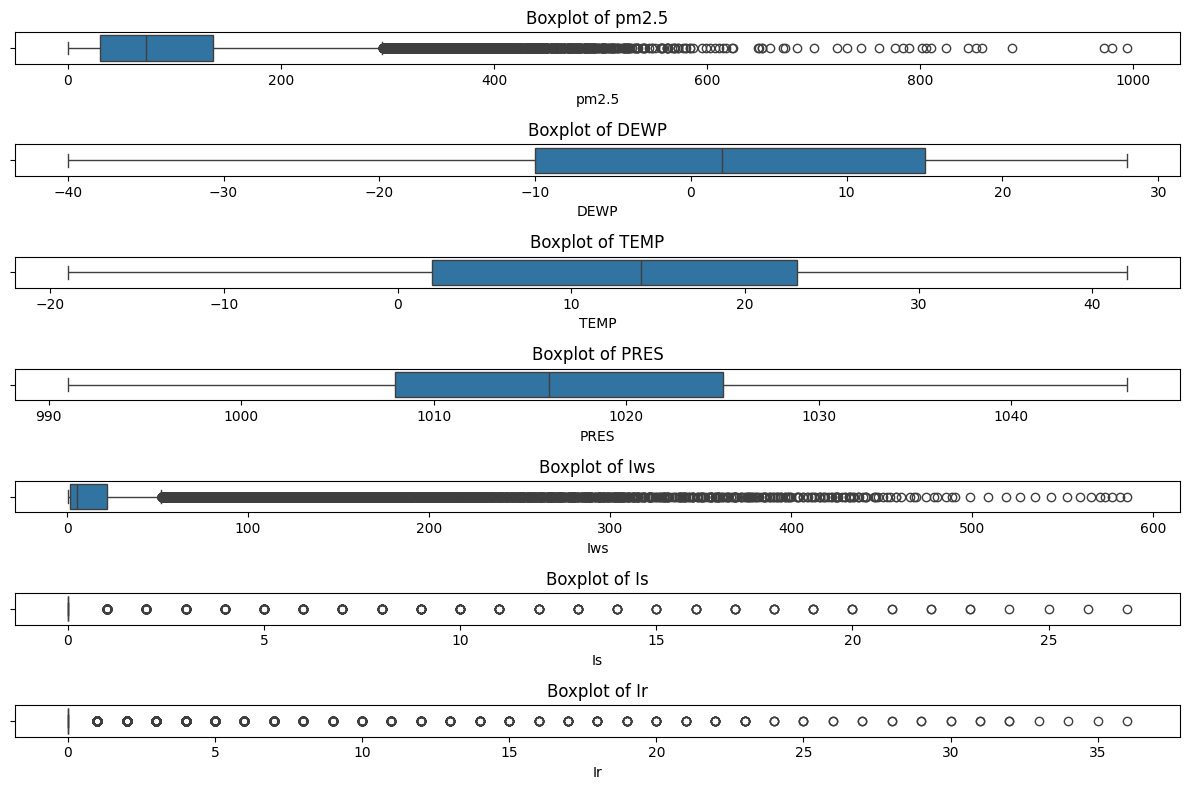

In [69]:
# Define numerical features for boxplots
numerical_features = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

# Create horizontal boxplots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)  # One feature per row
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

Frowm above boxplot , it is found that in pm2.5 clear outliers beyond 400, with some exceeding 600–800.

In IWS, numerous extreme outliers exceeding 300–500 m/s, with unrealistic values close to 600.

In IR, outliers clearly visible above 20 mm, but heavy rainfall may be valid in certain periods.

In IS, outliers visible beyond 15 mm, though snowfall in Beijing can vary widely.

So based on above observations remove outliers for features like pm2.5, Iws, Is, and Ir

In [70]:
# Function to remove outliers using IQR
def remove_outliers_iqr(data, features):
    for feature in features:
        Q1 = data[feature].quantile(0.25)  # First quartile (25th percentile)
        Q3 = data[feature].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 4.5 * IQR  # Lower threshold
        upper_bound = Q3 + 4.5 * IQR  # Upper threshold
        # Remove rows with outliers
        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    return data

# Features to clean
features_to_clean = ['pm2.5', 'Iws']

# Remove outliers
df_cleaned = remove_outliers_iqr(df, features_to_clean)

In [71]:
df.shape

(43824, 15)

In [72]:
df_cleaned.shape

(41564, 15)

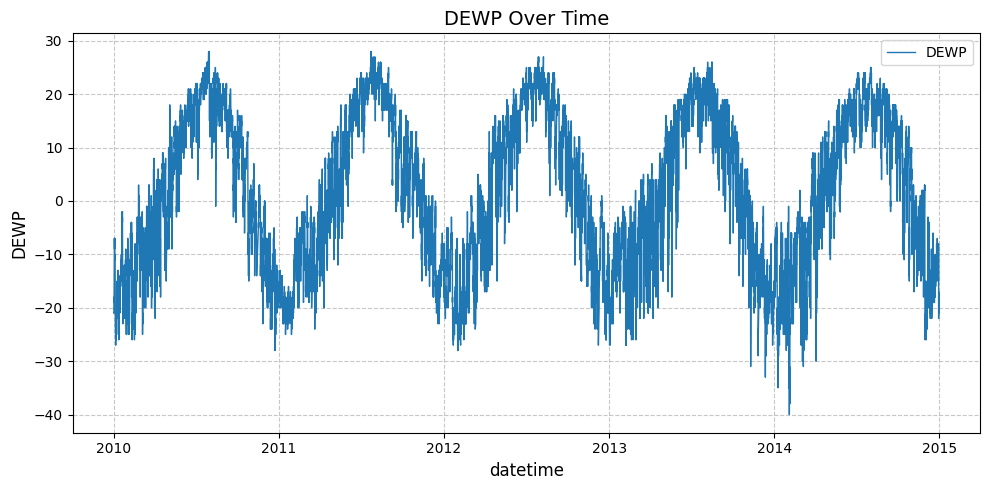

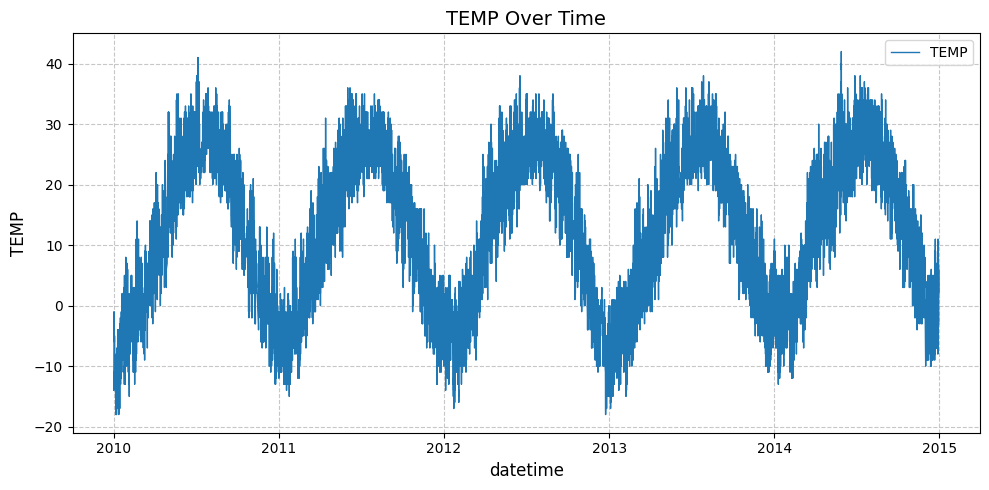

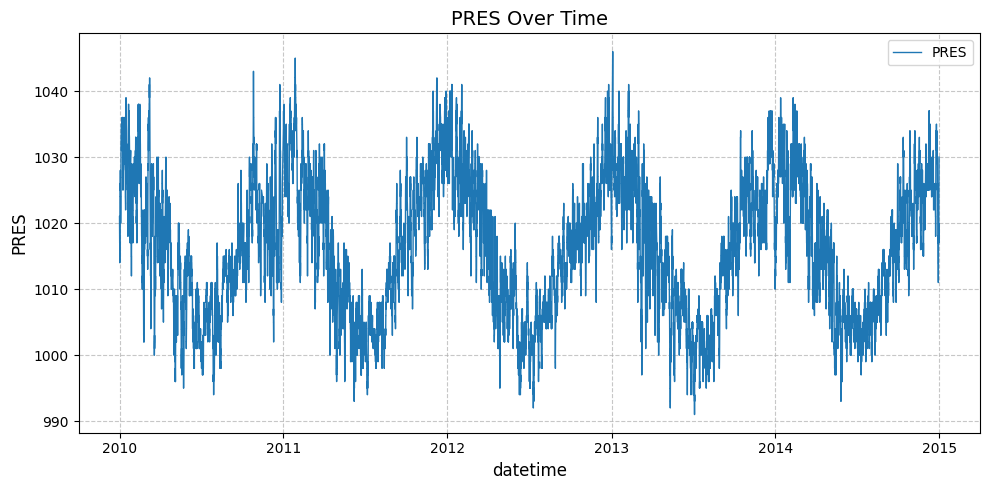

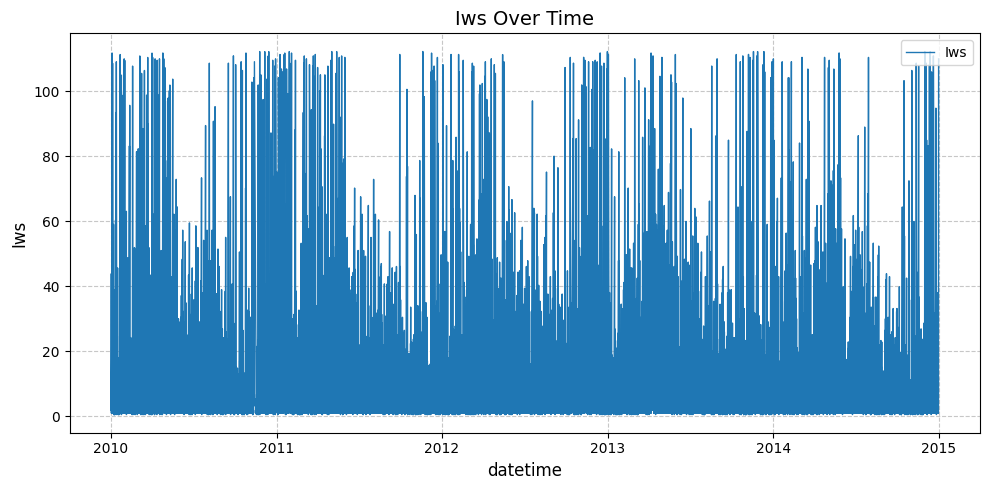

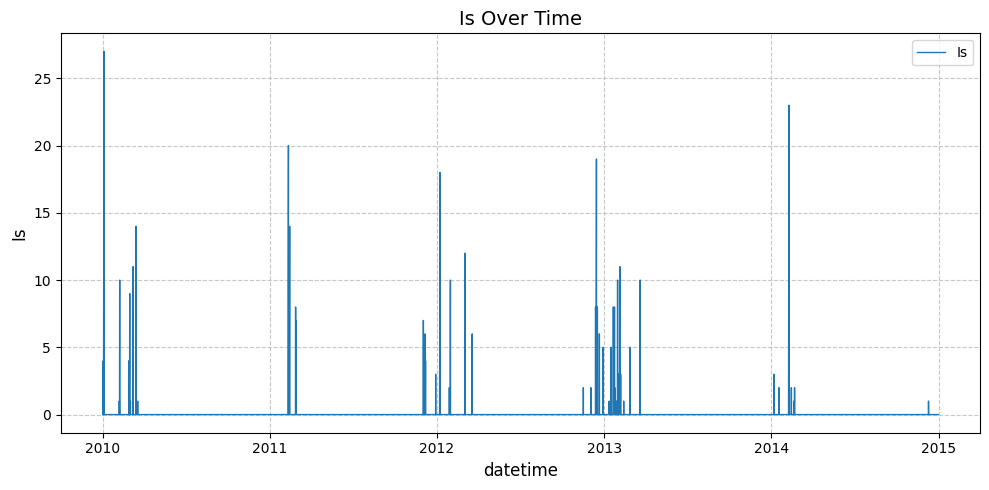

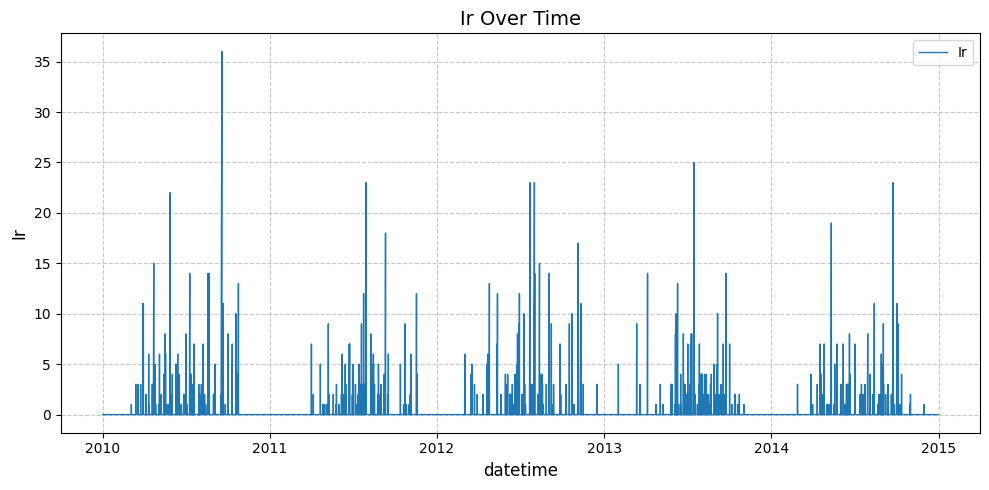

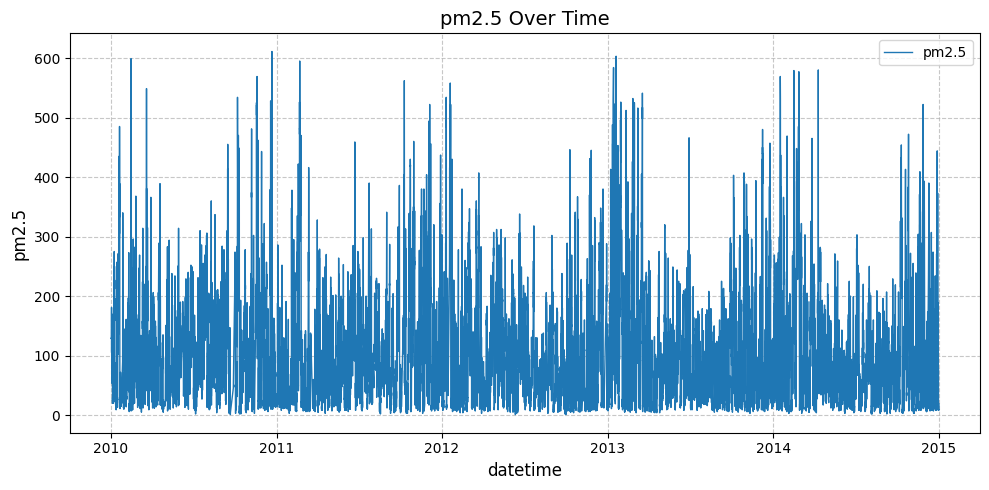

In [73]:
#build your line chart here
variables_to_plot = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']

# Plot each variable
for variable in variables_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(df_cleaned['datetime'], df_cleaned[variable], label=variable, linewidth=1)
    plt.title(f"{variable} Over Time", fontsize=14)
    plt.xlabel("datetime", fontsize=12)
    plt.ylabel(variable, fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Observations :

DEWP (Dew Point Temperature): exhibits clear seasonal patterns, peaking during summer and dipping during winter each year. Shows periodicity and consistent oscillations, indicating a strong correlation with the seasonal climate.

PM2.5 Concentration: Displays high variability, with significant spikes that could represent pollution events. No clear seasonal trend is evident, but the high peaks may correspond to specific external factors such as industrial activities, weather events, or seasonal burning.

TEMP (Temperature): Similar to DEWP, temperature follows a clear annual cycle with highs in summer and lows in winter. This consistency reflects the region’s climatic characteristics.

PRES (Pressure): Exhibits a subtle seasonal trend with periodic oscillations. There are shorter-term fluctuations superimposed on the seasonal trend, indicating weather variability.

IWS (Integrated Wind Speed): Displays irregular but persistent high variability over time. There is no apparent seasonal trend, suggesting that wind speed is influenced more by local or short-term weather systems rather than seasonal patterns.

From the above observations it is clear that and is evident that predicting the variables PM2.5 and IWS is challenging, as they exhibit high variability and do not follow clear seasonal patterns. Their behavior appears to be influenced by weather conditions and localized interactions with other features.

## Feature Engineering

/var/folders/1y/p5k2q_ms1kqfyyfj3ptdpwsc0000gn/T/ipykernel_76336/3975290602.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')  # 'M' represents monthly frequency


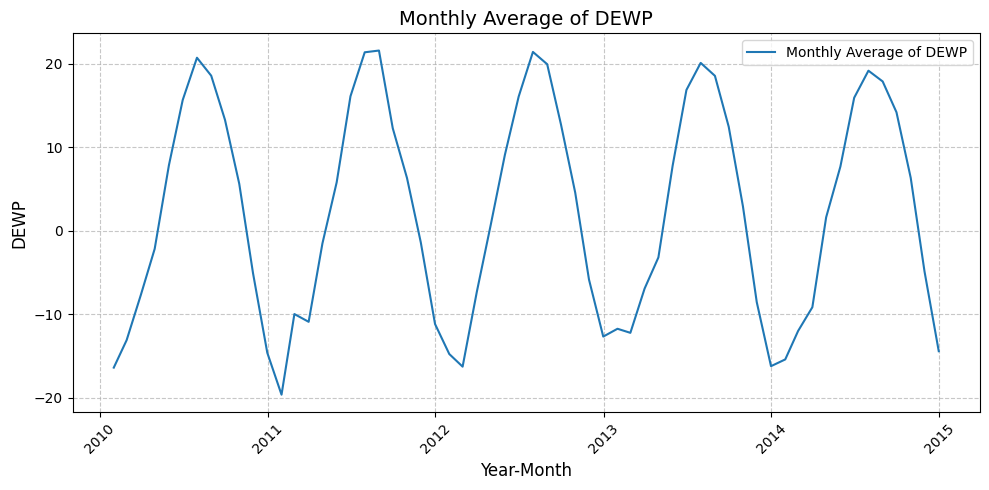

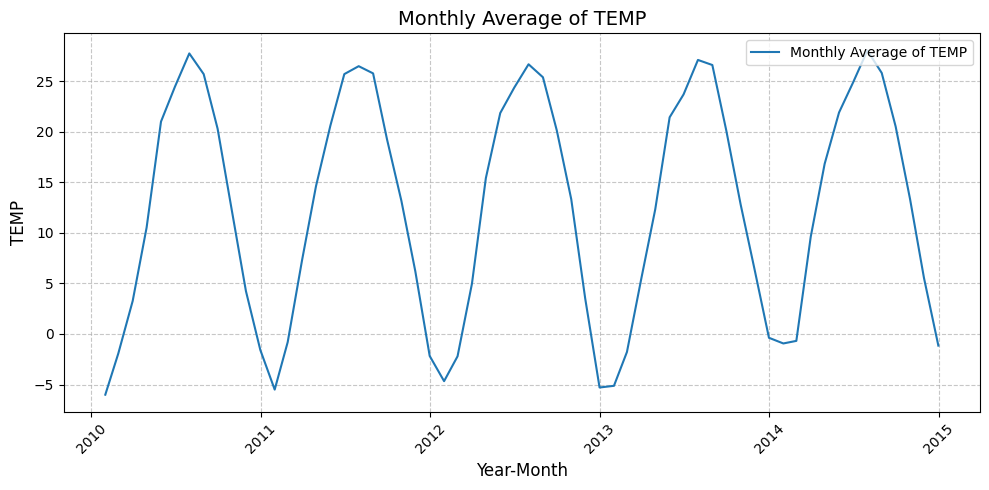

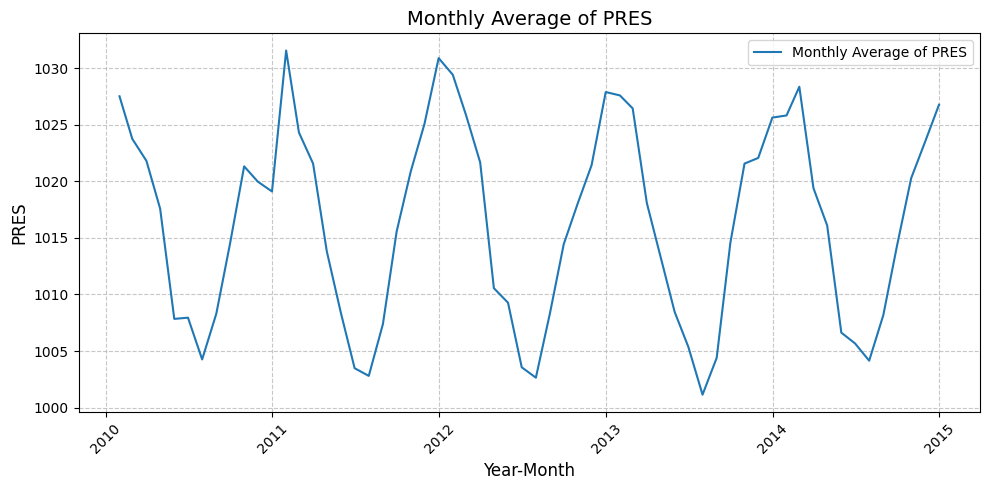

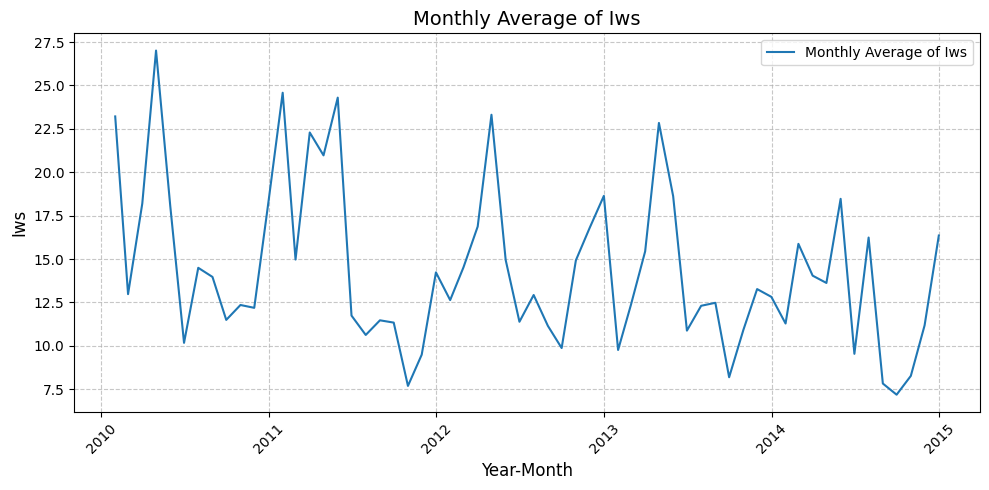

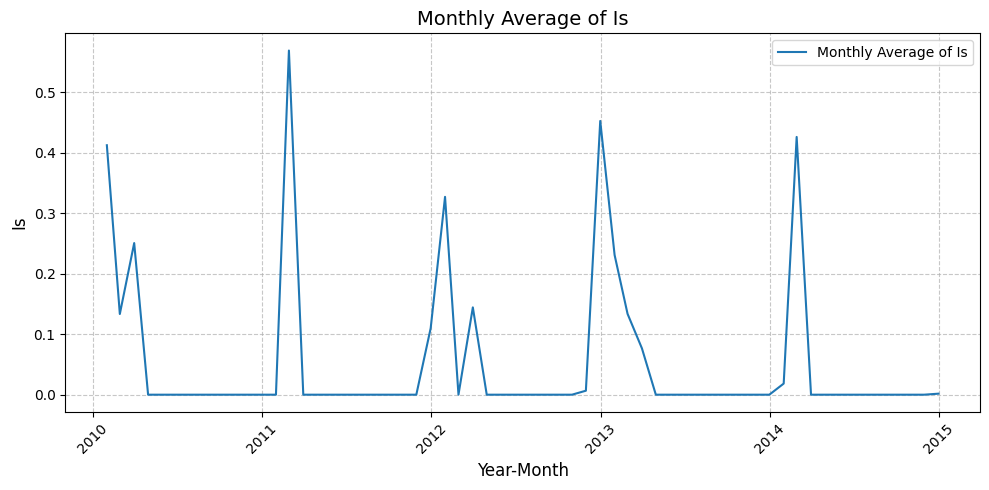

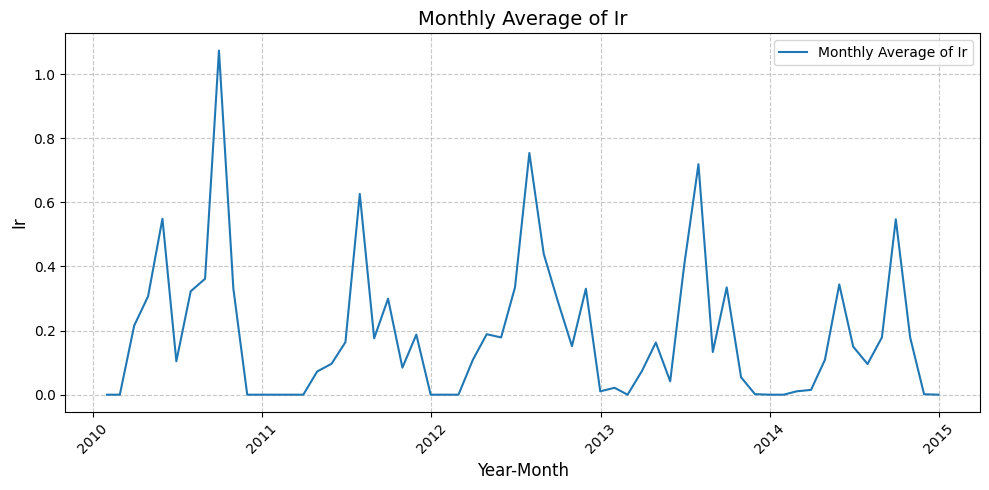

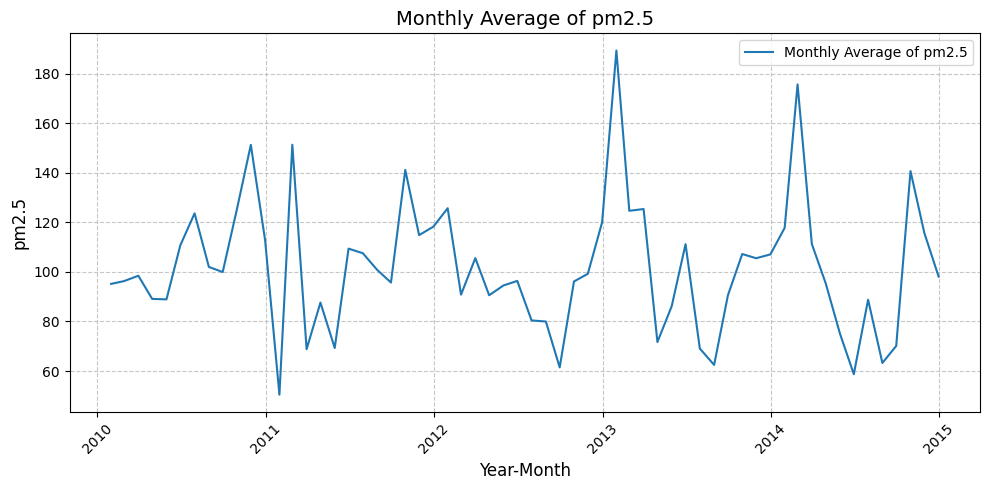

In [74]:
# Combine year, month, day, and hour to create 'Datetime'
df_cleaned['datetime'] = pd.to_datetime(df_raw[['year', 'month', 'day', 'hour']])

# 'Datetime' as the index
df_cleaned.set_index('datetime', inplace=True)

# Group by monthly intervals and calculate the mean
monthly_avg = df_cleaned.groupby(
    pd.Grouper(freq='M')  # 'M' represents monthly frequency
)[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','pm2.5']].mean().reset_index()

# Function to plot the monthly average
def plot_monthly_average(data, variables, datetime_column):
    for variable in variables:
        plt.figure(figsize=(10, 5))
        plt.plot(data[datetime_column], data[variable], label=f"Monthly Average of {variable}", linewidth=1.5)
        plt.title(f"Monthly Average of {variable}", fontsize=14)
        plt.xlabel("Year-Month", fontsize=12)
        plt.ylabel(variable, fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.legend(loc='upper right', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# the plotting function
plot_monthly_average(
    data=monthly_avg,
    variables=['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5'],
    datetime_column='datetime'
)

Uses a rolling window of 30 days (720 hours)

Computes the moving average for each selected feature

Uses min_periods=1 to prevent NaN values at the beginning

Stores results in a new DataFrame (df_moving_avg)

Processed 30-Day Moving Average Data:
             datetime  No  year  month  day  hour  pm2.5  DEWP       TEMP  \
0 2010-01-01 00:00:00   1  2010      1    1     0  129.0 -21.0 -11.000000   
1 2010-01-01 01:00:00   2  2010      1    1     1  129.0 -21.0 -11.500000   
2 2010-01-01 02:00:00   3  2010      1    1     2  129.0 -21.0 -11.333333   
3 2010-01-01 03:00:00   4  2010      1    1     3  129.0 -21.0 -12.000000   
4 2010-01-01 04:00:00   5  2010      1    1     4  129.0 -20.8 -12.000000   

      PRES cbwd       Iws   Is   Ir   unix_time  
0  1021.00   NW  1.790000  0.0  0.0  1262304000  
1  1020.50   NW  3.355000  0.0  0.0  1262307600  
2  1020.00   NW  4.473333  0.0  0.0  1262311200  
3  1019.75   NW  5.815000  0.0  0.0  1262314800  
4  1019.40   NW  7.246000  0.0  0.0  1262318400  


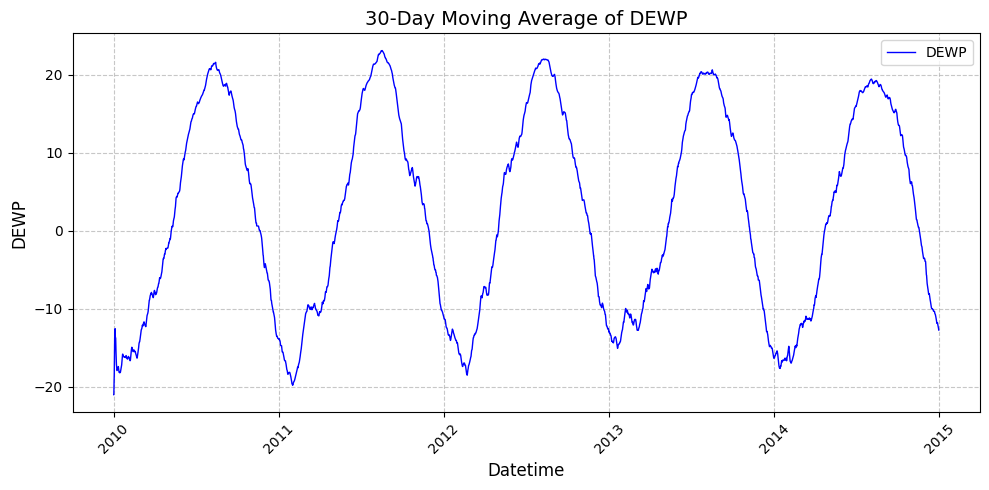

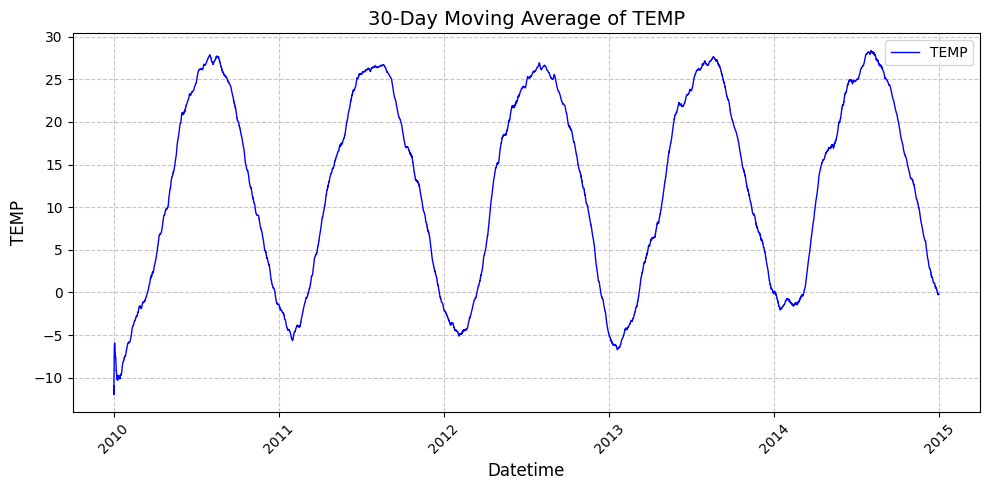

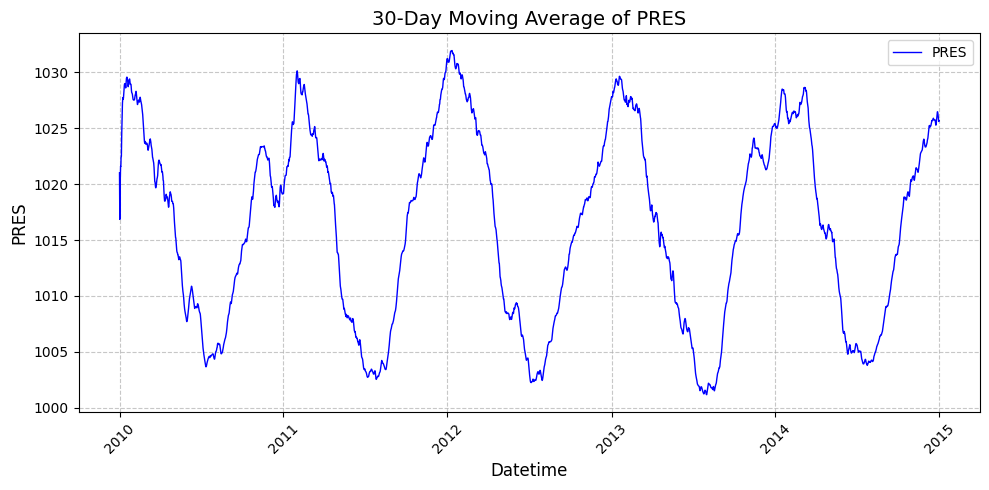

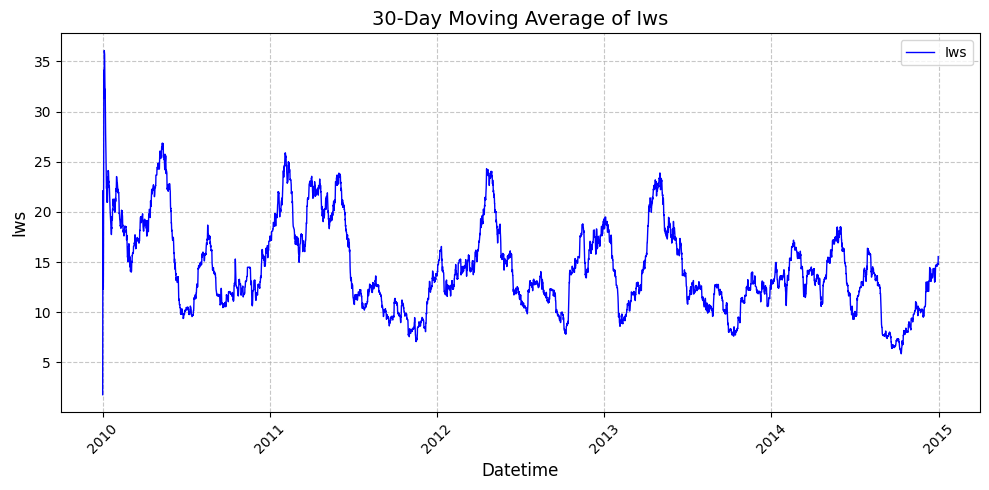

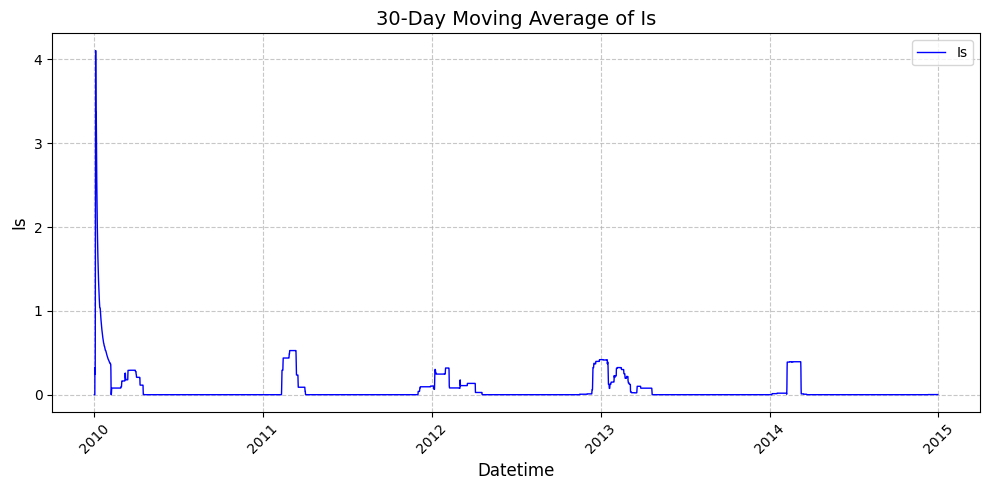

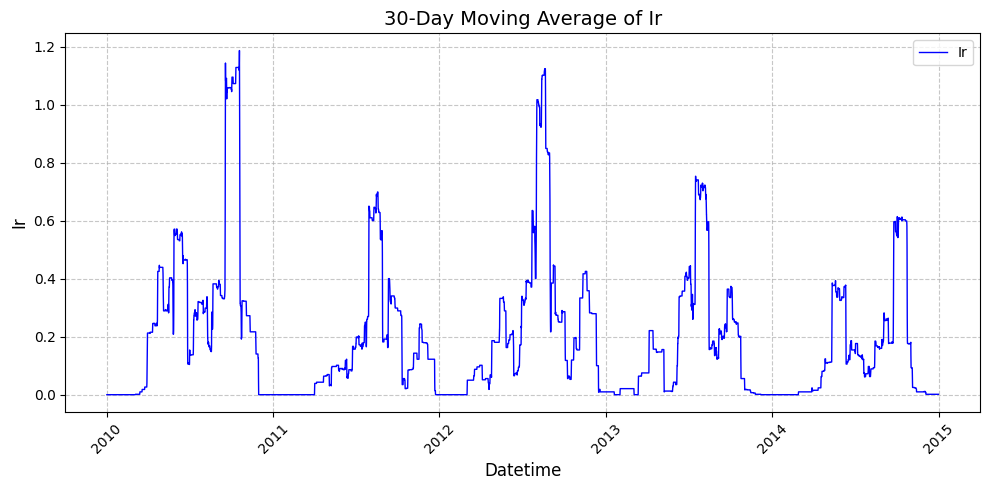

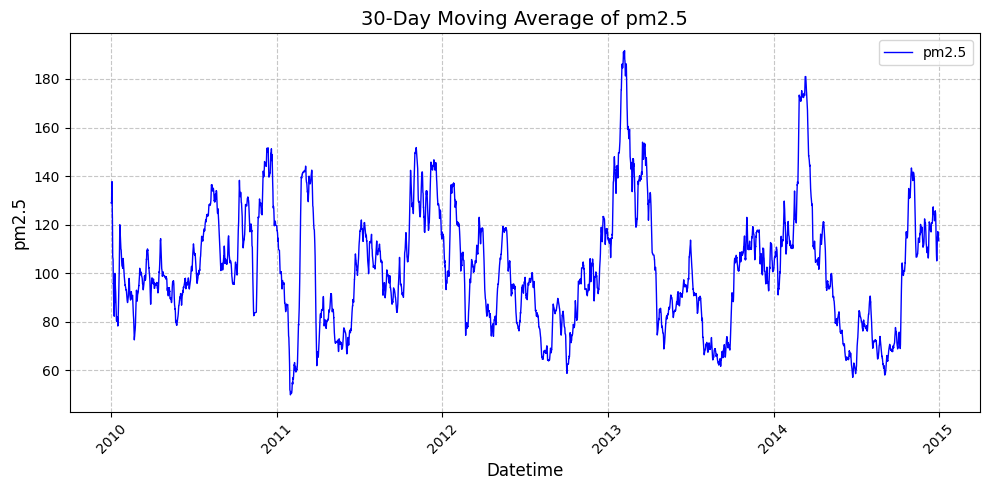

In [75]:
df_moving_avg = df_cleaned.copy()

# Check if 'datetime' is an index, reset it if necessary
if df_moving_avg.index.name == 'datetime':
    df_moving_avg.reset_index(inplace=True)

if 'datetime' not in df_moving_avg.columns:
    raise KeyError("The 'datetime' column is missing from the dataset. Check column names.")

# Converting datetime column to datetime format
df_moving_avg['datetime'] = pd.to_datetime(df_moving_avg['datetime'])

# 'datetime' as index for time-based rolling window
df_moving_avg.set_index('datetime', inplace=True)

# Define the rolling window size (30 days = 720 hours)
window_size = 30 * 24  # Time-based rolling window of 30 days

# List of features to apply the moving average
features_to_smooth = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']

# Apply 30-day moving average using time-based rolling
df_moving_avg[features_to_smooth] = df_moving_avg[features_to_smooth].rolling(window=window_size, min_periods=1).mean()

# Reset index to keep datetime as a column again
df_moving_avg.reset_index(inplace=True)

# Display first few rows
print("Processed 30-Day Moving Average Data:")
print(df_moving_avg.head())

# Save the processed dataframe to a CSV file (optional)
df_moving_avg.to_csv("30_day_moving_avg_data.csv", index=False)

# Plot the moving averages
for variable in ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']:
    plt.figure(figsize=(10, 5))
    plt.plot(df_moving_avg['datetime'], df_moving_avg[variable], label=variable, linewidth=1, color='blue')
    plt.title(f"30-Day Moving Average of {variable}", fontsize=14)
    plt.xlabel("Datetime", fontsize=12)
    plt.ylabel(variable, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



By observing at the above plots it clearly explans that rolling/moving average describes the patters very well for predictions. 

So as part of feature engineering we would like to perform some rolling features on pm2.5 and Iws .

### Feature Engineering

In [76]:
wind_mapping = {'NW': 1, 'NE': 2, 'SW': 3, 'SE': 4}
df_cleaned['cbwd_encoded'] = df_cleaned['cbwd'].map(wind_mapping)

wind_angles = {'NW': 315, 'NE': 45, 'SW': 225, 'SE': 135}  # Approximate wind angles
df_cleaned['cbwd_angle'] = df_cleaned['cbwd'].map(wind_angles)
df_cleaned['cbwd_sin'] = np.sin(np.radians(df_cleaned['cbwd_angle']))
df_cleaned['cbwd_cos'] = np.cos(np.radians(df_cleaned['cbwd_angle']))

In [77]:
df_cleaned.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,unix_time,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos
datetime,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,1.79,0,0,1262304000,1.0,315.0,-0.707107,0.707107
2010-01-01 01:00:00,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,4.92,0,0,1262307600,1.0,315.0,-0.707107,0.707107
2010-01-01 02:00:00,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,6.71,0,0,1262311200,1.0,315.0,-0.707107,0.707107
2010-01-01 03:00:00,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,9.84,0,0,1262314800,1.0,315.0,-0.707107,0.707107
2010-01-01 04:00:00,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,12.97,0,0,1262318400,1.0,315.0,-0.707107,0.707107


Smooth time-series data by calculating rolling averages (e.g., 3-hour, 24-hour).

Include lagged values for important features (e.g., PM2.5, IWS).

In [78]:
df_cleaned['pm2.5_rolling_3h'] = df_cleaned['pm2.5'].rolling(window=3).mean()
df_cleaned['pm2.5_rolling_24h'] = df_cleaned['pm2.5'].rolling(window=24).mean()

df_cleaned['pm2.5_lag_1'] = df_cleaned['pm2.5'].shift(1)
df_cleaned['Iws_lag_1'] = df_cleaned['Iws'].shift(1)

# daily averages for pm2.5
df_cleaned['day_avg_pm2.5'] = df_cleaned.groupby(['year', 'month', 'day'])['pm2.5'].transform('mean')

# temparature dew-point spread which impacts air-quality
df_cleaned['temp_dew_spread'] = df_cleaned['TEMP'] - df_cleaned['DEWP']

# interaction feature between windspeed and rainfall which affects pm2.5 dispersion
df_cleaned['Iws_rain_interaction'] = df_cleaned['Iws'] * df_cleaned['Ir']

In [79]:
df_cleaned.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,pm2.5_lag_1,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,...,315.0,-0.707107,0.707107,NaN,NaN,NaN,NaN,129.0,10.0,0.0
2010-01-01 01:00:00,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,...,315.0,-0.707107,0.707107,NaN,NaN,129.0,1.79,129.0,9.0,0.0
2010-01-01 02:00:00,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,...,315.0,-0.707107,0.707107,129.0,NaN,129.0,4.92,129.0,10.0,0.0
2010-01-01 03:00:00,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,...,315.0,-0.707107,0.707107,129.0,NaN,129.0,6.71,129.0,7.0,0.0
2010-01-01 04:00:00,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,...,315.0,-0.707107,0.707107,129.0,NaN,129.0,9.84,129.0,8.0,0.0


In [80]:
# Display the list of columns in the dataset
column_list = df_cleaned.columns.tolist()
print(column_list)

['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'unix_time', 'cbwd_encoded', 'cbwd_angle', 'cbwd_sin', 'cbwd_cos', 'pm2.5_rolling_3h', 'pm2.5_rolling_24h', 'pm2.5_lag_1', 'Iws_lag_1', 'day_avg_pm2.5', 'temp_dew_spread', 'Iws_rain_interaction']


Lets take a look at correlation matrix for the main features of original dataframe

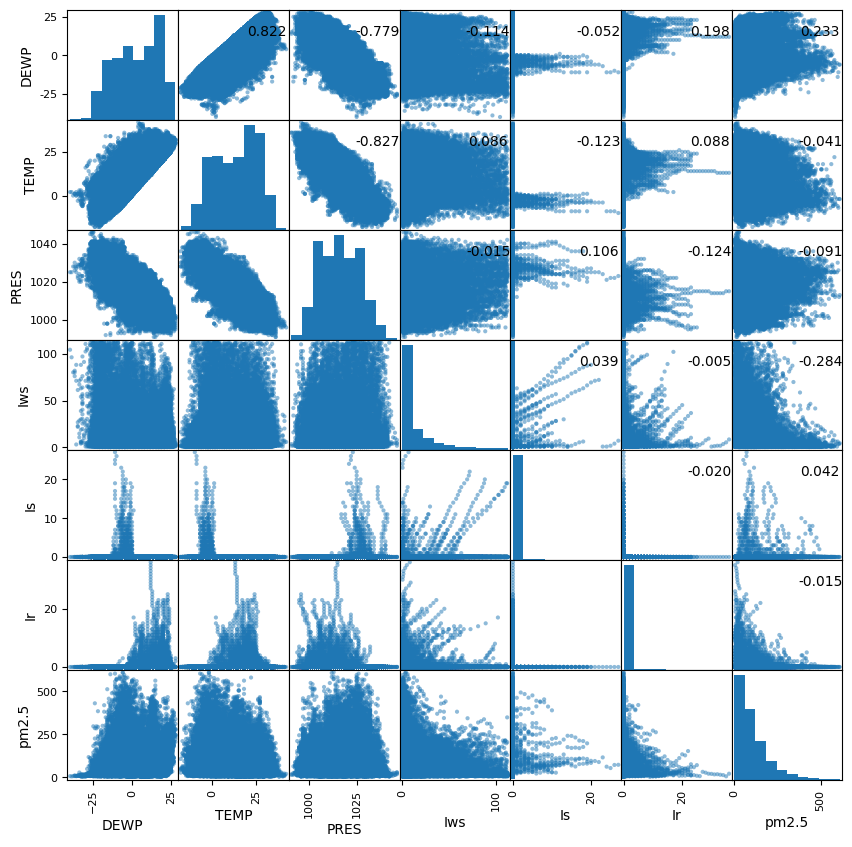

In [81]:
axes = pd.plotting.scatter_matrix(df_cleaned[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','pm2.5', ]], alpha=0.5,figsize = [10,10])
corr = df_cleaned[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','pm2.5']].corr(method = 'spearman').to_numpy() #nonlinear
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

Correlation Matrix:
                          DEWP      TEMP      PRES       Iws        Is  \
DEWP                  1.000000  0.823091 -0.772402 -0.168479 -0.039533   
TEMP                  0.823091  1.000000 -0.821179 -0.007660 -0.097268   
PRES                 -0.772402 -0.821179  1.000000  0.036138  0.076793   
Iws                  -0.168479 -0.007660  0.036138  1.000000  0.076745   
Is                   -0.039533 -0.097268  0.076793  0.076745  1.000000   
Ir                    0.129442  0.052516 -0.077317 -0.010051 -0.010139   
unix_time             0.043889  0.074401 -0.018420 -0.074690 -0.027585   
cbwd_encoded          0.344509  0.351740 -0.278232 -0.054805  0.034224   
cbwd_angle           -0.240193 -0.215470  0.156380  0.193307 -0.017991   
cbwd_sin              0.303200  0.289536 -0.219566 -0.152597  0.026170   
cbwd_cos             -0.333159 -0.349854  0.281322  0.002450 -0.035010   
pm2.5_rolling_3h      0.130000 -0.123527 -0.016011 -0.221256  0.018051   
pm2.5_rolling_24h 

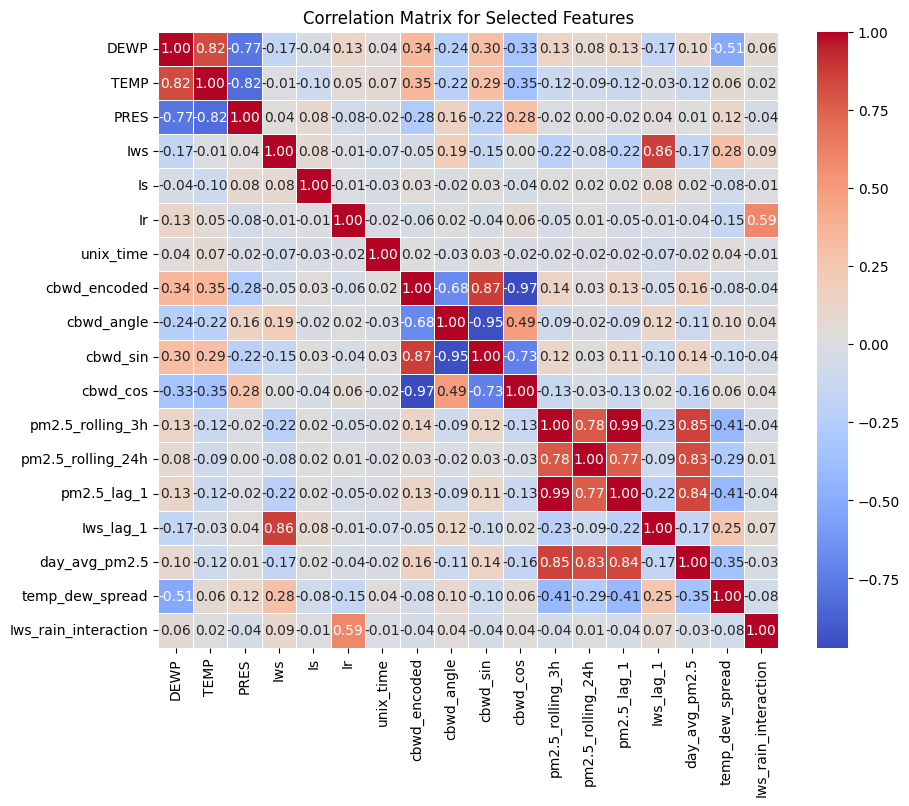

In [82]:
# Select the features of interest
selected_features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'unix_time', 'cbwd_encoded', 'cbwd_angle',	'cbwd_sin',	'cbwd_cos', 'pm2.5_rolling_3h', 'pm2.5_rolling_24h', 'pm2.5_lag_1', 'Iws_lag_1', 'day_avg_pm2.5', 'temp_dew_spread', 'Iws_rain_interaction']
df_selected = df_cleaned[selected_features]

# Compute the correlation matrix
correlation_matrix = df_selected.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Selected Features")
plt.show()

In [83]:
df_cleaned.dtypes

No                        int64
year                      int64
month                     int64
day                       int64
hour                      int64
pm2.5                   float64
DEWP                      int64
TEMP                    float64
PRES                    float64
cbwd                     object
Iws                     float64
Is                        int64
Ir                        int64
unix_time                 int64
cbwd_encoded            float64
cbwd_angle              float64
cbwd_sin                float64
cbwd_cos                float64
pm2.5_rolling_3h        float64
pm2.5_rolling_24h       float64
pm2.5_lag_1             float64
Iws_lag_1               float64
day_avg_pm2.5           float64
temp_dew_spread         float64
Iws_rain_interaction    float64
dtype: object

In [84]:
features_to_remove = ['pm2.5_lag_1', 'cbwd', 'unix_time', 'No', 'year', 'month', 'day', 'hour']
df_cleaned = df_cleaned.drop(columns=features_to_remove, errors='ignore')

In [85]:
df_cleaned.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
datetime,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,129.0,-21,-11.0,1021.0,1.79,0,0,1.0,315.0,-0.707107,0.707107,NaN,NaN,NaN,129.0,10.0,0.0
2010-01-01 01:00:00,129.0,-21,-12.0,1020.0,4.92,0,0,1.0,315.0,-0.707107,0.707107,NaN,NaN,1.79,129.0,9.0,0.0
2010-01-01 02:00:00,129.0,-21,-11.0,1019.0,6.71,0,0,1.0,315.0,-0.707107,0.707107,129.0,NaN,4.92,129.0,10.0,0.0
2010-01-01 03:00:00,129.0,-21,-14.0,1019.0,9.84,0,0,1.0,315.0,-0.707107,0.707107,129.0,NaN,6.71,129.0,7.0,0.0
2010-01-01 04:00:00,129.0,-20,-12.0,1018.0,12.97,0,0,1.0,315.0,-0.707107,0.707107,129.0,NaN,9.84,129.0,8.0,0.0


## Normalize the dataset

In [86]:
from sklearn.preprocessing import MinMaxScaler

# Exclude 'datetime' from normalization if it exists
exclude_features = ['datetime']
features_to_normalize = [col for col in df_cleaned.columns if col not in exclude_features]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to selected features
df_scaled_values = scaler.fit_transform(df_cleaned[features_to_normalize])

# Convert back to DataFrame with original column names
df_scaled = pd.DataFrame(df_scaled_values, columns=features_to_normalize)

# # Add back the excluded datetime feature if it exists
# if 'datetime' in df_moving_avg.columns:
#     df_scaled['datetime'] = df_moving_avg['datetime']

# # Reorder columns to maintain original structure
# if 'datetime' in df_scaled.columns:
#     df_scaled = df_scaled[['datetime'] + features_to_normalize]

# Display first few rows
print("MinMax Scaled Dataset (Excluding datetime):")
print(df_scaled.head())

# Optional: Save the final dataset
df_scaled.to_csv("minmax_scaled_dataset.csv", index=False)

MinMax Scaled Dataset (Excluding datetime):
      pm2.5      DEWP      TEMP      PRES       Iws   Is   Ir  cbwd_encoded  \
0  0.209836  0.279412  0.116667  0.545455  0.011988  0.0  0.0           0.0   
1  0.209836  0.279412  0.100000  0.527273  0.039989  0.0  0.0           0.0   
2  0.209836  0.279412  0.116667  0.509091  0.056003  0.0  0.0           0.0   
3  0.209836  0.279412  0.066667  0.509091  0.084004  0.0  0.0           0.0   
4  0.209836  0.294118  0.100000  0.490909  0.112006  0.0  0.0           0.0   

   cbwd_angle  cbwd_sin  cbwd_cos  pm2.5_rolling_3h  pm2.5_rolling_24h  \
0         1.0       0.0       1.0               NaN                NaN   
1         1.0       0.0       1.0               NaN                NaN   
2         1.0       0.0       1.0          0.211346                NaN   
3         1.0       0.0       1.0          0.211346                NaN   
4         1.0       0.0       1.0          0.211346                NaN   

   Iws_lag_1  day_avg_pm2.5  temp_de

In [87]:
# Display only the 'datetime' column if it exists
if 'datetime' in df_scaled.columns:
    print(df_scaled[['datetime']].head())
else:
    print("⚠️ Warning: 'datetime' column is not present in df_scaled.")

⚠️ Warning: 'datetime' column is not present in df_scaled.


In [34]:
# scaled_df = merged_df.drop(columns='cbwd', errors='ignore')


In [88]:
# the file path where you want to save the CSV
file_path = "feature_eng_data.csv"

# Save the DataFrame to a CSV file
df_scaled.to_csv(file_path, index=True)  # Include the index (Datetime) in the CSV

# Confirm the file was saved
print(f"DataFrame saved to {file_path}")

DataFrame saved to feature_eng_data.csv


In [89]:
df_scaled.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
0,0.209836,0.279412,0.116667,0.545455,0.011988,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,0.256663,0.211538,0.0
1,0.209836,0.279412,0.100000,0.527273,0.039989,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,0.011988,0.256663,0.192308,0.0
2,0.209836,0.279412,0.116667,0.509091,0.056003,0.0,0.0,0.0,1.0,0.0,1.0,0.211346,NaN,0.039989,0.256663,0.211538,0.0
3,0.209836,0.279412,0.066667,0.509091,0.084004,0.0,0.0,0.0,1.0,0.0,1.0,0.211346,NaN,0.056003,0.256663,0.153846,0.0
4,0.209836,0.294118,0.100000,0.490909,0.112006,0.0,0.0,0.0,1.0,0.0,1.0,0.211346,NaN,0.084004,0.256663,0.173077,0.0


In [90]:
df_5000_rows = df_scaled.iloc[1000:6000]

In [91]:
df_5000_rows.shape

(5000, 17)

### Objective 1 : Predict the target variale PM2.5

### creating sequences for LSTM

In [ ]:
import numpy as np

def create_sequences(data, target_column, time_steps=24, predict_days=7):
    X, y = [], []
    prediction_steps = predict_days * 24  # Number of hours for 7 days
    
    for i in range(len(data) - time_steps - prediction_steps + 1):
        X.append(data.iloc[i:i + time_steps].values)  # Past `time_steps` values
        # Collect the next 7 days (24 hours * 7 days)
        y.append(data.iloc[i + time_steps:i + time_steps + prediction_steps][target_column].values)
    
    return np.array(X), np.array(y)


# Define parameters
time_steps = 30 * 24  # Past 30 days of data
predict_days = 10 # Predict the next 10 hours
target_column = 'pm2.5'

# Calculate the number of features from the DataFrame
num_features = df_5000_rows.shape[1]  # Number of features in the DataFrame

# Create sequences
X, y = create_sequences(df_5000_rows, target_column, time_steps, predict_days)

# Confirm X and y are not empty (check if data is large enough for sequence creation)
if len(X) == 0 or len(y) == 0:
    raise ValueError("Not enough data to create sequences. Increase the number of rows in the DataFrame.")

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape X to match LSTM input shape (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], time_steps, num_features))
X_test = X_test.reshape((X_test.shape[0], time_steps, num_features))

# Print shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3232, 720, 17), y_train shape: (3232, 240)
X_test shape: (809, 720, 17), y_test shape: (809, 240)


In [ ]:
# import numpy as np

# def create_sequences(data, target_column, time_steps=24):
#     X, y = [], []
    
#     for i in range(len(data) - time_steps):
#         X.append(data.iloc[i:i + time_steps].values)  # Past `time_steps` values
#         y.append(data.iloc[i + time_steps][target_column])  # Next timestep's PM2.5
    
#     return np.array(X), np.array(y)

# # Get the first 50 rows of the DataFrame
# #df_50_rows = df.head(50)  # Replace `df` with your actual DataFrame name

# # Define time window (e.g., past 30 days * 24 hours to predict the next hour)
# time_steps = 30 * 24
# target_column = 'pm2.5'

# # Calculate the number of features from the DataFrame
# num_features = df_5000_rows.shape[1]  # Number of features in the DataFrame

# # Create sequences
# X, y = create_sequences(df_5000_rows, target_column, time_steps)

# # confirm X and y are not empty (check if data is large enough for sequence creation)
# if len(X) == 0 or len(y) == 0:
#     raise ValueError("Not enough data to create sequences. Increase the number of rows in the DataFrame.")

# # Split into train and test sets (80% train, 20% test)
# train_size = int(len(X) * 0.8)
# X_train, y_train = X[:train_size], y[:train_size]
# X_test, y_test = X[train_size:], y[train_size:]

# # Reshape X to match LSTM input shape (samples, time_steps, features)
# X_train = X_train.reshape((X_train.shape[0], time_steps, num_features))
# X_test = X_test.reshape((X_test.shape[0], time_steps, num_features))

# # Print shapes to verify
# print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")  # Should be (samples, time_steps, features)

Train shape: (3424, 720, 17), Test shape: (856, 720, 17)


### Build the LSTM Model

In [134]:
# Define LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, num_features)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer (predicting PM2.5)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.000001), loss='mse', metrics=['mae'])

# Display model summary
model.summary()

/Users/swathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 720, 100)       │        47,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 720, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,701 (307.43 KB)

 Trainable params: 78,701 (307.43 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model with Early Stopping

In [135]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (3232, 720, 17), X_test shape: (809, 720, 17)
y_train shape: (3232, 240), y_test shape: (809, 240)


In [136]:
# Convert data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [137]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (3232, 720, 17)
X_test shape: (809, 720, 17)


In [138]:
print(f"NaN in X_train: {np.isnan(X_train).sum()}")
print(f"NaN in y_train: {np.isnan(y_train).sum()}")
print(f"NaN in X_test: {np.isnan(X_test).sum()}")
print(f"NaN in y_test: {np.isnan(y_test).sum()}")

print(f"Inf in X_train: {np.isinf(X_train).sum()}")
print(f"Inf in y_train: {np.isinf(y_train).sum()}")
print(f"Inf in X_test: {np.isinf(X_test).sum()}")
print(f"Inf in y_test: {np.isinf(y_test).sum()}")

NaN in X_train: 1850336
NaN in y_train: 0
NaN in X_test: 434312
NaN in y_test: 0
Inf in X_train: 0
Inf in y_train: 0
Inf in X_test: 0
Inf in y_test: 0


In [139]:
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

In [140]:
# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - loss: 0.0169 - mae: 0.1002 - val_loss: 0.0120 - val_mae: 0.0823
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - loss: 0.0169 - mae: 0.1010 - val_loss: 0.0118 - val_mae: 0.0826
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - loss: 0.0164 - mae: 0.1006 - val_loss: 0.0118 - val_mae: 0.0830
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - loss: 0.0158 - mae: 0.0991 - val_loss: 0.0117 - val_mae: 0.0831
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - loss: 0.0162 - mae: 0.1001 - val_loss: 0.0117 - val_mae: 0.0830
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1011s 10s/step - loss: 0.0162 - mae: 0.1000 - val_loss: 0.0117 - val_mae: 0.0829
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 5149s 51s/step - loss: 0.0157 - mae: 0.0989 - val_loss: 0.0116 - val_mae: 0.0828
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1431s 14s/step - loss: 0.0158 - mae: 0.0989 - val_loss: 0.0116 - val_mae: 0.0827
Epoch 9/50
101/101 ━━━━━━━━━━━━━

### Evaluate the model

In [141]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0109 - mae: 0.0782
Test Loss: 0.0116, Test MAE: 0.0823


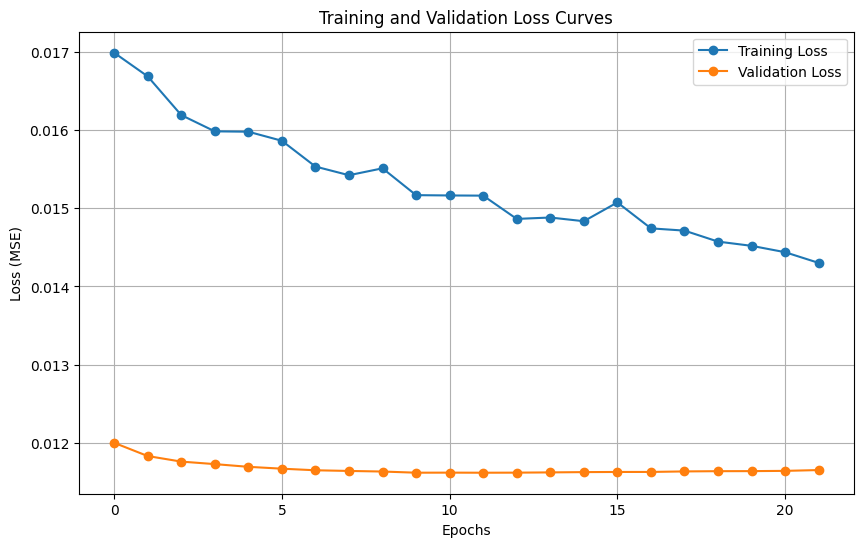

In [142]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

### mark predictions and compare values

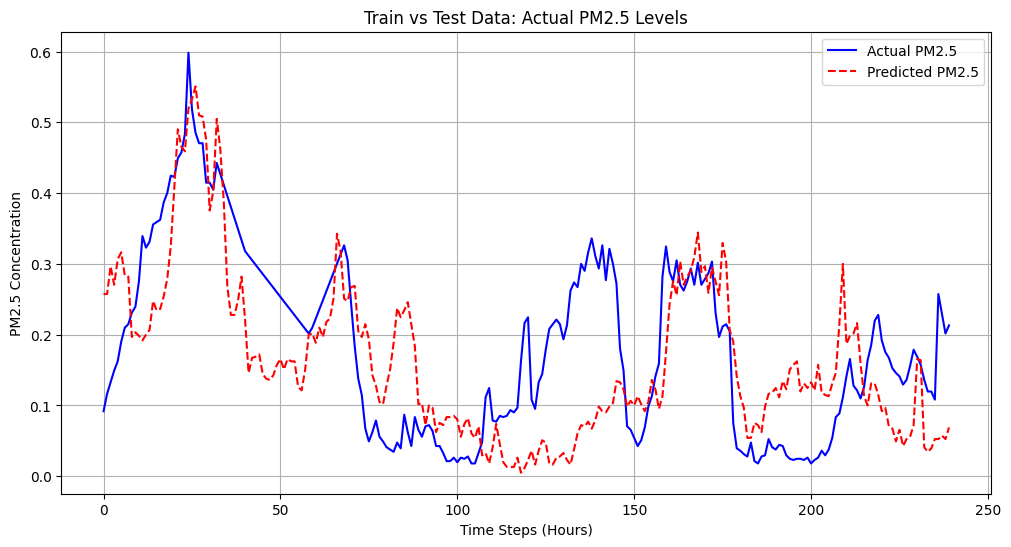

In [146]:
import matplotlib.pyplot as plt

# Select indices of sequences to compare
train_index = 239  # Index of the training sequence to compare
test_index = 239  # Index of the test sequence to compare

# Plot y_train and y_test on the same graph
plt.figure(figsize=(12, 6))
plt.plot(y_train[train_index], label='Actual PM2.5', color='blue')
plt.plot(y_test[test_index], label='Predicted PM2.5', color='red', linestyle='dashed')
plt.title('Train vs Test Data: Actual PM2.5 Levels')
plt.xlabel('Time Steps (Hours)')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()

### Objective 1 : Predict the target variale IWS

In [154]:

# Define parameters
time_steps = 30 * 24  # Past 30 days of data
predict_days = 10 # Predict the next 10 hours
target_column = 'Iws'

# Calculate the number of features from the DataFrame
num_features = df_5000_rows.shape[1]  # Number of features in the DataFrame

# Create sequences
X, y = create_sequences(df_5000_rows, target_column, time_steps, predict_days)

# Confirm X and y are not empty (check if data is large enough for sequence creation)
if len(X) == 0 or len(y) == 0:
    raise ValueError("Not enough data to create sequences. Increase the number of rows in the DataFrame.")

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape X to match LSTM input shape (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], time_steps, num_features))
X_test = X_test.reshape((X_test.shape[0], time_steps, num_features))

# Print shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3232, 720, 17), y_train shape: (3232, 240)
X_test shape: (809, 720, 17), y_test shape: (809, 240)


In [156]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.000001), loss='mse', metrics=['mae'])

# Display model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 720, 100)       │        47,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 720, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,701 (307.43 KB)

 Trainable params: 78,701 (307.43 KB)

 Non-trainable params: 0 (0.00 B)

In [157]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Convert data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

print(f"NaN in X_train: {np.isnan(X_train).sum()}")
print(f"NaN in y_train: {np.isnan(y_train).sum()}")
print(f"NaN in X_test: {np.isnan(X_test).sum()}")
print(f"NaN in y_test: {np.isnan(y_test).sum()}")

print(f"Inf in X_train: {np.isinf(X_train).sum()}")
print(f"Inf in y_train: {np.isinf(y_train).sum()}")
print(f"Inf in X_test: {np.isinf(X_test).sum()}")
print(f"Inf in y_test: {np.isinf(y_test).sum()}")

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

X_train shape: (3232, 720, 17), X_test shape: (809, 720, 17)
y_train shape: (3232, 240), y_test shape: (809, 240)
NaN in X_train: 1850336
NaN in y_train: 0
NaN in X_test: 434312
NaN in y_test: 0
Inf in X_train: 0
Inf in y_train: 0
Inf in X_test: 0
Inf in y_test: 0


In [158]:
# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 249ms/step - loss: 0.0440 - mae: 0.1576 - val_loss: 0.0263 - val_mae: 0.1349
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - loss: 0.0434 - mae: 0.1545 - val_loss: 0.0254 - val_mae: 0.1306
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - loss: 0.0428 - mae: 0.1521 - val_loss: 0.0248 - val_mae: 0.1276
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 253ms/step - loss: 0.0420 - mae: 0.1496 - val_loss: 0.0245 - val_mae: 0.1257
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 254ms/step - loss: 0.0429 - mae: 0.1493 - val_loss: 0.0243 - val_mae: 0.1245
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - loss: 0.0428 - mae: 0.1495 - val_loss: 0.0241 - val_mae: 0.1231
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 27s 264ms/step - loss: 0.0418 - mae: 0.1477 - val_loss: 0.0239 - val_mae: 0.1222
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - loss: 0.0418 - mae: 0.1467 - val_loss: 0.0239 - val_mae: 0.1219
Epoch 9/50
101/101 ━━━━━━━━━━━━━

In [159]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0290 - mae: 0.1219
Test Loss: 0.0229, Test MAE: 0.1122


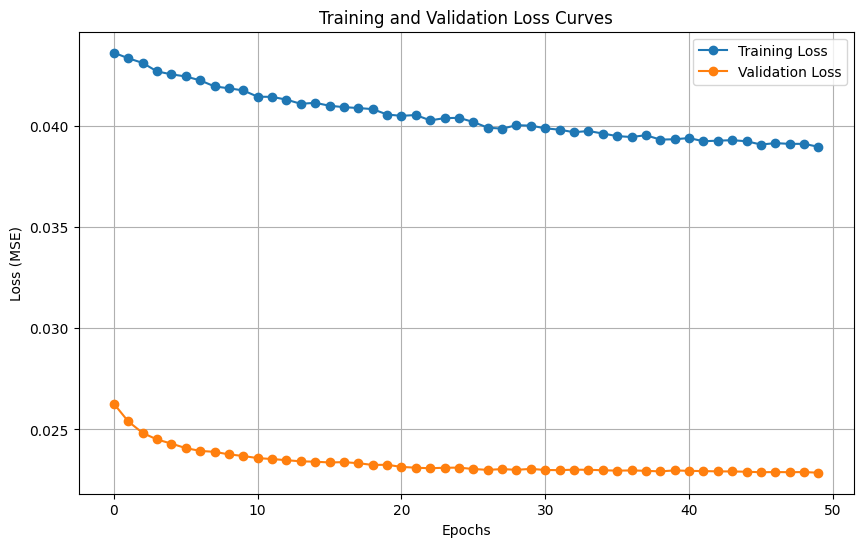

In [160]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

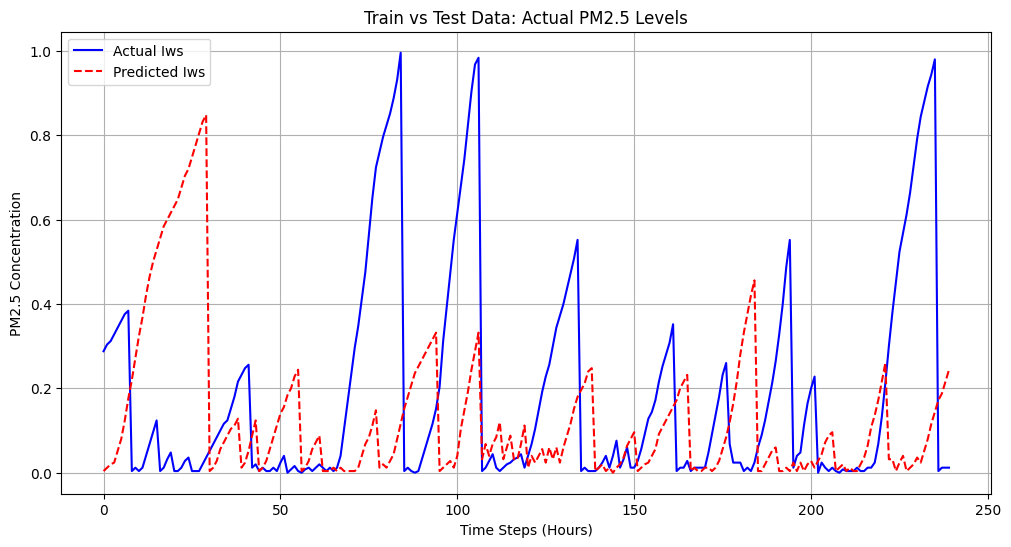

In [161]:
import matplotlib.pyplot as plt

# Select indices of sequences to compare
train_index = 239  # Index of the training sequence to compare
test_index = 239  # Index of the test sequence to compare

# Plot y_train and y_test on the same graph
plt.figure(figsize=(12, 6))
plt.plot(y_train[train_index], label='Actual Iws', color='blue')
plt.plot(y_test[test_index], label='Predicted Iws', color='red', linestyle='dashed')
plt.title('Train vs Test Data: Actual PM2.5 Levels')
plt.xlabel('Time Steps (Hours)')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()